<center><h1>Comparitive Analysis of Translation APIs for Nepali to English Transcription</h1></center>

| **API** | **Nepali Support** | **Cost** | **Pros** | **Cons** |
|------|---------------|------|----------|------|
| **Google Cloud Translation API** | ✅ Yes | \$20 per million characters | Fast, widely used, supports many languages | Can be expensive at scale |
| **Microsoft Azure Translator** | ✅ Yes | \$10 per million characters | Good enterprise integration, strong NLP models | Pricing complexity |
| **DeepL API** | ❌ No | \$20 per million characters + \$4.99/month | High accuracy for major languages | No support for Nepali |
| **Yandex API** | ✅ Yes | €5.99/month for 500K characters; €0.00002 per extra | Affordable, decent quality | Lower accuracy for niche languages |
| **Whisper Built-in Translation** | 🟨 Yes * | Free (open-source) | Integrated with Whisper, good for audio | Slower, not accurate for Nepali to English |
| **Amazon Translate** | ❌ No | \$15 per million characters; first 2M free (12 months) | Scalable, good neural translation | May require AWS-specific setup |
| **IBM Watson Translator** |  🟨 Yes * | Lite: 1M free/month; Standard: \$0.02 per 1K characters | Customizable models | Discontinued service |
| **OpenAI (ChatGPT API)** | ✅ Yes | \$0.0020 per 1K tokens (~750 words) | Context-aware, nuanced translations | Costly for large texts, slower batch processing |
| **Google Gemini API** | 🟨 Yes * | Free tier, then token-based pricing | AI-powered, context-aware translation | No dedicated translation API, recommends Google Translate API |


# Data

To test the actual cost, efficiency, and accuracy of the non-excluded API options above, we can use timed API calls on a known testing text. English-Nepali pretranslated resourse was provided by [Paracrawl](https://paracrawl.eu/). English-Nepali V1 contains 92,084 sentences, which should be a sufficient base for translation accuracy while reducing token cost for the more extensive V2 file.

# Testing




In [ ]:
!pip install pandas
!pip install google-cloud-translate
!pip install --upgrade openai
!pip install transformers
!pip install nltk
!pip install requests
!pip install boto3
!pip install numpy
!pip install sentence-transformers

Setup functions, all run statements separated.

In [ ]:
import os
import uuid
import csv
import time
import requests
import openai
import boto3
import nltk
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from google.cloud import translate_v2 as translate
import numpy as np
from sentence_transformers import SentenceTransformer, util
from openai import OpenAI

# Project Directory, modify for personally selected filepath
project_directory = ''
os.chdir(project_directory)

# Authentication for Google Translate API, enter your credential json filepath.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""
google_client = translate.Client()

# Authentication for Azure Translate API, enter your credential key here.
azure_subscription_key = ''
azure_endpoint = 'https://api.cognitive.microsofttranslator.com/'

# Authentication for Yandex Translate API, enter your credential key here.
yandex_api_key = ''

# Authentication for AWS Translate API, enter your credentials here.
aws_client = boto3.client(
        'translate',
        region_name='',
        aws_access_key_id='',
        aws_secret_access_key=''
    )

# Authentication for OpenAI API, enter your credential key here.
os.environ["OPENAI_API_KEY"] = ""
openai_client = OpenAI()

# This function reformats the Bicleaner txt format into a 2-column csv with English,Nepali headers.
def process_paracrawl_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['English', 'Nepali'])
        for line in infile:
            if not line.strip():
                continue
            parts = line.strip().split('\t')
            if len(parts) == 2:
                english_text, nepali_text = parts
                writer.writerow([english_text, nepali_text])
            else:
                print(f"Skipping line due to unexpected format: {line.strip()}")

# This function selects a given range of the Nepali text blocks and prepares a string for the API calls.
def prepare_text(file, column, start_index, width=1):
    if not os.path.exists(file):
        print(f"Error: The file {file} does not exist.")
        return None
    df = pd.read_csv(file).dropna()
    if column >= len(df.columns):
        print(f"Error: Column index {column} out of range. Available columns: {df.columns}")
        return None
    if start_index >= len(df):
        print(f"Error: Start index {start_index} is out of range for the dataset of size {len(df)}")
        return None
    selected_data = df.iloc[start_index : start_index + width, column].tolist()
    return selected_data if len(selected_data) > 1 else selected_data[0]


# Google Translate API call
def translate_text_google(text, target_language="en"):
    if isinstance(text, list):  # If the input is a list of texts
        result = google_client.translate(text, target_language=target_language)
        return [res['translatedText'] for res in result]

    result = google_client.translate(text, target_language=target_language)
    return result['translatedText']

# Azure Translate API call
def translate_text_azure(text, subscription_key=azure_subscription_key, endpoint=azure_endpoint, target_language="en"):
    path = '/translate?api-version=3.0'
    params = f'&to={target_language}'
    url = endpoint + path + params
    headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Ocp-Apim-Subscription-Region': "eastus",
    'Content-type': 'application/json',
    'X-ClientTraceId': str(uuid.uuid4())
    }
    body = [{'text': text}]
    response = requests.post(url, headers=headers, json=body)

    if response.status_code == 200:
        return response.json()[0]['translations'][0]['text']
    else:
        return f"Error: {response.status_code}, {response.text}"

# Yandex Translate API call
def translate_text_yandex(text, target_language='en', api_key=yandex_api_key):
    url = "https://translate.yandex.net/api/v1.5/tr.json/translate"
    params = {
        'key': api_key,
        'text': text,
        'lang': target_language
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        translated_text = response.json().get('text', [])[0]
        return translated_text
    else:
        return f"Error: {response.status_code}"

# AWS Translation API call
def translate_text_amazon(text, target_language='en', source_language=None):
    response = aws_client.translate_text(
        Text=text,
        SourceLanguageCode=source_language if source_language else 'auto',
        TargetLanguageCode=target_language
    )
    translated_text = response['TranslatedText']
    return translated_text

# OpenAI API call
def translate_text_openai(text, target_language='English'):
    try:
        system_message = f"You are an expert translator. Translate the following text into {target_language}, preserving meaning, context, and style."
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"Please translate the following text into {target_language}: {text}"}
        ]

        # Start the streaming request
        stream = openai_client.chat.completions.create(
            model="gpt-4",  # Or you can use "gpt-3.5-turbo" depending on your model
            messages=messages,
            stream=True
        )

        # Process and print the streamed content
        translated_text = ""
        for chunk in stream:
            if chunk.choices[0].delta.content is not None:
                translated_text += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="")

        # Return the final translated text
        return translated_text.strip()

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Tokenizes expected vs actual and calculates BLEU score (an industry standard for translation accuracy comparison)
def calculate_bleu(expected, actual):
    expected_tokens = expected.strip().split()
    actual_tokens = actual.strip().split()
    bleu_score = sentence_bleu([expected_tokens], actual_tokens)
    return bleu_score

# Calculates the number of insertions and deletions needed to get the expected result
def calculate_wer(expected, actual):
    ref_words = expected.split()
    hyp_words = actual.split()
    distance_matrix = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))

    for i in range(len(ref_words) + 1):
        distance_matrix[i][0] = i
    for j in range(len(hyp_words) + 1):
        distance_matrix[0][j] = j

    # Compute Levenshtein distance
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i - 1] == hyp_words[j - 1]:
                distance_matrix[i][j] = distance_matrix[i - 1][j - 1]
            else:
                substitution = distance_matrix[i - 1][j - 1] + 1
                insertion = distance_matrix[i][j - 1] + 1
                deletion = distance_matrix[i - 1][j] + 1
                distance_matrix[i][j] = min(substitution, insertion, deletion)

    wer = distance_matrix[len(ref_words)][len(hyp_words)] / len(ref_words) * 100
    return wer

from sentence_transformers import SentenceTransformer, util

def calculate_semantic_similarity(expected, actual):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    ref_embedding = model.encode(expected, convert_to_tensor=True)
    hyp_embedding = model.encode(actual, convert_to_tensor=True)
    similarity_score = util.cos_sim(ref_embedding, hyp_embedding).item()
    return similarity_score

# This is where the magic happens
def api_tester(api_index=0):
    api_mapping = {
        0: {'csv': 'google_translate_results.csv', 'function': translate_text_google, 'name': 'Google'},
        1: {'csv': 'azure_translate_results.csv', 'function': translate_text_azure, 'name': 'Azure'},
        2: {'csv': 'openai_translate_results.csv', 'function': translate_text_openai, 'name': 'OpenAI'}
    }

    api_info = api_mapping.get(api_index)
    if not api_info:
        print("Invalid API index")
        return

    api_results = api_info['csv']
    translate_function = api_info['function']
    api_name = api_info['name']

    print(f"\n{'='*30}\nStarting translation test for {api_name} API...\n{'='*30}")

    if os.path.exists(api_results):
        results_df = pd.read_csv(api_results)
        print(f"Loaded existing CSV: {api_results}")
    else:
        results_df = pd.DataFrame(columns=["Nepali Text", "Expected Text", "Actual Text", "Translation Time (s)", "Bleu Score", "Word Error Rate", "Semantic Similarity", "Total Score"])
        print(f"Created new results file: {api_results}")

    selected_range = 25
    block_size = 1

    for x in range(0, selected_range, block_size):
        print(f"\n{'-'*20}\nProcessing block {x + 1}/{selected_range}...\n{'-'*20}")

        try:
            nepali_text = prepare_text(translation_file, 1, x, block_size)
            expected = prepare_text(translation_file, 0, x)
            print(f"Original Nepali: {nepali_text}")
            print(f"Expected English: {expected}")
        except Exception as e:
            print(f"Error reading text at index {x}: {e}")
            continue

        try:
            start_time = time.time()
            actual = translate_function(nepali_text)
            end_time = time.time()
            translation_time = end_time - start_time
            bleu_score = calculate_bleu(expected, actual)
            wer = calculate_wer(expected, actual)
            semantic_similarity = calculate_semantic_similarity(expected, actual)
            normalized_wer = 1 - (wer / 100)
            total_score = (0.4 * normalized_wer) + (0.4 * semantic_similarity) + (0.2 * bleu_score)
            print(f"Translated: {actual}")
            print(f"Time: {translation_time:.2f}s | BLEU: {bleu_score:.4f} | WER: {wer:.2f}% | Semantic Similarity: {semantic_similarity:.2f}")
            print(f"Total Score: {total_score:.4f}")
        except Exception as e:
            print(f"Translation failed for index {x}: {e}")
            continue

        results_df.loc[len(results_df)] = [nepali_text, expected, actual, translation_time, bleu_score, wer, semantic_similarity, total_score]


    results_df.to_csv(api_results, index=False)
    print(f"\n{'='*30}\nTranslation test for {api_name} API completed. Results saved to {api_results}\n{'='*30}")


Prepare translation text as a csv for easy comparison and storage.

In [100]:
text_file = 'en-ne.txt'
translation_file = 'formatted_translation.csv'
process_paracrawl_file(text_file, translation_file)


Call the API(s)

In [101]:
# Loop through every API
for i in range(3):
    api_tester(i)

# If desired, call api_tester on a single API:
# 0 = google
# 1 = azure
# 2 = openai
# api_tester(2)


Starting translation test for Google API...
Created new results file: google_translate_results.csv

--------------------
Processing block 1/25...
--------------------
Original Nepali: न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक विद्यार्थी विश्वविद्यालय गरेको नौ कलेज को एक विनियोजन गरिएको छ. नवौं कलेज मा स्थापित भएको थियो 2014 र रोमन सम्राट Constantine महान् पछि नाम थियो Constantine, जो मा योर्क अगस्तस घोषणा भएको थियो 306 ई. त्यहाँ निकट भविष्यमा दशौं कलेज निर्माण गर्ने योजना हो.
Expected English: York is a collegiate university and every student is allocated to one of the university’s nine colleges. The ninth college was founded in 2014 and was named Constantine after the Roman emperor Constantine the Great, who was proclaimed Augustus in York in 306 AD.
Translated: New York is a collegiate university and each student is assigned to one of the university&#39;s nine colleges. The ninth college was founded in 2014 and was named after the Roman Emperor Constantine the Great, who was pr

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The library, which the school opened with in 1868, began with 1,039 volumes. Later, President Edmund J. James, in a speech to the Board of Trustees in 1912, proposed to create a research library. It is now one of the largest public educational collections in the world. In 1870, the Mumford House was built as a model barn for the school&#39;s experimental farm. The Mumford House remains the oldest structure on campus. The original University Hall (1871) was the 4th building built; it stood where the Illini Union stands today.
Time: 0.23s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.39
Total Score: 0.1543

--------------------
Processing block 4/25...
--------------------
Original Nepali: यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS मा लोड जो ANSI.SYS चालक अन्तर्खण्ड छन्। यो ट्रोजन अन केही कुञ्जीहरू redefines
Expected English: These sequences are intercepted by the ANSI.SYS driver which is loaded in CONFIG.SYS on a number of PC’s. The trojan redefines some keys on 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: + View HSK&#39;s player statistics games, goals, assists, kort mm
Time: 0.09s | BLEU: 0.0000 | WER: 70.00% | Semantic Similarity: 0.79
Total Score: 0.4357

--------------------
Processing block 7/25...
--------------------
Original Nepali: तपाईं एक खेल Enlai चाहनुहुन्छ भने [...]
Expected English: A racing game attractive B [...]


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: If you want a game Enlai [...]
Time: 0.14s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.39
Total Score: 0.1566

--------------------
Processing block 8/25...
--------------------
Original Nepali: कात्तिक ११ गते नागरिकमा प्रकाशित प्रकाश तिमल्सिनाले काठमाडौं डेटलाइनमा तयार पारेको समाचार “राष्ट्रपति आज चुनिँदै” मा नाम नखुलाइएको राष्ट्रपति कार्यालय स्रोतलाई उद्धृत गरिएको छ। नागरिकमा प्रकाशित पूर्ण बस्नेतले काठमा... विस्तारमा
Expected English: Anonymous sources in newspapers of August 24 Annapurna Post report headlined “Deuba-Modi hold surprise meeting” datelined New Delhi has quoted unnamed source in one instance: Officials. Annapurna Post report headlined “Ministries in mess a... Read More


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: An unnamed source from the Presidential Office was quoted in the news item “President to be elected today” prepared by Prakash Timalsina for Kathmandu Dateline, published in Nagarik on Kartik 11. Purna Basnet, published in Nagarik, reported that in Kathmandu... In detail
Time: 0.17s | BLEU: 0.0000 | WER: 113.89% | Semantic Similarity: 0.51
Total Score: 0.1487

--------------------
Processing block 9/25...
--------------------
Original Nepali: न्यूक्यासल सम्पर्क स्वयंसेवी केन्द्र न्यूक्यासल मा व्यापक स्वयं सेवा मौका, Broadacre हाउस, बजार सडक, NE1 6HQ: फोन: 0191 3389696 इमेल: karen.watson@volunteermatters.org.uk वेबसाइट: volunteercentrenewcastle.org.uk
Expected English: For wider volunteering opportunities in Newcastle contact the Volunteer Centre Newcastle, Broadacre House, Market Street, NE1 6HQ: Phone: 0191 3389696 Email: karen.watson@volunteermatters.org.uk Website: volunteercentrenewcastle.org.uk
Translated: Newcastle Contact Volunteer Center Extensive volunteering oppor

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: IQ OPTION official letter to affiliate regarding this information:
Time: 0.12s | BLEU: 0.0000 | WER: 77.78% | Semantic Similarity: 0.94
Total Score: 0.4657

--------------------
Processing block 11/25...
--------------------
Original Nepali: 19:6 किनभने यो, हेर, दिन पुग्न छन्, प्रभु भन्छन्, जब यो ठाउँ अब Topheth भनिन्छ गरिनेछ, वा Hinnom छोरा को उपत्यका, तर वध को उपत्यका.
Expected English: 19:6 Because of this, behold, the days are approaching, says the Lord, when this place will no longer be called Topheth, or the valley of the son of Hinnom, but the Valley of Slaughter .
Translated: 19:6 For behold, the days come, saith the Lord, that this place shall no more be called Topheth, or the valley of the son of Hinnom, but the valley of slaughter.
Time: 0.09s | BLEU: 0.4322 | WER: 34.29% | Semantic Similarity: 0.96
Total Score: 0.7350

--------------------
Processing block 12/25...
--------------------
Original Nepali: "शिपिपोनर्स र बिल्डर्स जसले विश्वका सबैभन्दा क्रांतिकारी भाँ

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Label height 15-150 mm
Time: 0.08s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.99
Total Score: 0.3940

--------------------
Processing block 14/25...
--------------------
Original Nepali: सन्देशहरू, iMessage, सम्पर्क, कल इतिहास, Facetime, क्यालेन्डर, स्मरणकर्ता, नोट्स, सफारी पुस्तकचिनो, तस्वीरहरु, भिडियो
Expected English: Nuncia perferentes, iMessage, Contacts, Call History, Facetime, Calendar, Reminders, Notes, Safari Bookmarks, imaginibus, Videos Compriment imaginibus eximo sursum spatio enim machinae
Translated: Messages, iMessage, Contacts, Call History, Facetime, Calendar, Reminders, Notes, Safari Bookmarks, Photos, Videos
Time: 0.16s | BLEU: 0.4074 | WER: 47.62% | Semantic Similarity: 0.63
Total Score: 0.5436

--------------------
Processing block 15/25...
--------------------
Original Nepali: ओमेगा, पहिलो र अन्तिम: र देख्नु के तिमी, एक मा लेख्न
Expected English: Omega, the first and the last: and what thou seest, write in a
Translated: Omega, the first and

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Space Weather Festival in Moscow.
Time: 0.08s | BLEU: 0.0000 | WER: 20.00% | Semantic Similarity: 1.00
Total Score: 0.7200

--------------------
Processing block 17/25...
--------------------
Original Nepali: श्रीमती पुरुष भएको थाहा पाएपछि - NayaNaulo.com - Nepali News
Expected English: Police brutality caught on camera in Bihar - NayaNaulo.com - Nepali News
Translated: After finding out that his wife is a man - NayaNaulo.com - Nepali News
Time: 0.13s | BLEU: 0.2658 | WER: 75.00% | Semantic Similarity: 0.48
Total Score: 0.3468

--------------------
Processing block 18/25...
--------------------
Original Nepali: आज हामीले एउटा लेख लेख्न GTA 5 New Rp Glitch After 1.08. तपाईं GTA खोजिरहेको भने 5 पैसा Hack तपाईं सही ठाँउ मा हो! यो लेख पढ्ने राख्न, GTA 5 New Rp Glitch After 1.08 र तपाईं को लागि देख रहे के प्राप्त हुनेछ.
Expected English: Today we write an article about GTA 5 Cheats PS3 Unlimited Money. If you are looking for GTA 5 Money Hack you are on the right place! Keep read

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Supreme Court upholds decision to deploy army in riot-hit areas – YesKathmandu.com
Time: 0.10s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.26
Total Score: 0.1035

--------------------
Processing block 20/25...
--------------------
Original Nepali: प्रमुख बिपक्षी माओवादीले बैशाख १९ गतेदेखि अनिश्चिकालीन देशव्यापी आमहड्ताल घोषणा गरेको छ । सामान्य आन्दोलनलाई सरकारले ध्यान नदिएकाले अनिश्चिकालीन हड्तालमा उत्रनु परेको माओवादी स्पष्टोक्ति छ । सोमबार राजधानीमा पत्रकार सम्मेलन गरी माओवादी अध्यक्ष पुष्पकमल दाहालले आन्दोलन काठमाडौंसहित देशभरका सदरमुकाम र शहर केन्द्रीत हुने जानकारी दिए । 'शान्ति र संविधानका लागि बैशाख १९ गतेदेखि अनिश्चितकालीन राजनीतिक हड्ताल घोषणा गरिएको छ,' दाहालले भने, 'यो हाम्रो रहर नभएर बाध्यता हो ।'
Expected English: At the invitation of Premier Li Keqiang of the State Council of the People's Republic of China, K P Sharma Oli, Prime Minister of Nepal is on an official visit to China from June 19 to 24, 2018. Besides Beijing, Prime Minister Oli is set to 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The main opposition Maoists have declared an indefinite nationwide general strike from April 19. The Maoists have made it clear that they had to go on an indefinite strike because the government did not pay attention to the general movement. Addressing a press conference in the capital on Monday, Maoist Chairman Pushpa Kamal Dahal informed that the movement would be centered in district headquarters and cities across the country, including Kathmandu. &#39;An indefinite political strike has been declared from April 19 for peace and the constitution,&#39; Dahal said, &#39;This is not our desire but a compulsion.&#39;
Time: 0.16s | BLEU: 0.0000 | WER: 141.54% | Semantic Similarity: 0.39
Total Score: -0.0112

--------------------
Processing block 21/25...
--------------------
Original Nepali: 16 तर युद्ध भइरहेको समयमा ती पाँचजना राजाहरू भागेर गए। तिनीहरू मक्केदा नजिकको एक गुफामा लुके।
Expected English: 16 For the five kings were fled, and had hidden themselves in a cave of the 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: 16 But during the battle, the five kings fled and hid in a cave near Makkedah.
Time: 0.12s | BLEU: 0.0000 | WER: 73.68% | Semantic Similarity: 0.80
Total Score: 0.4244

--------------------
Processing block 22/25...
--------------------
Original Nepali: | @ यूसुफको भाइहरूले आफ्नो बुबा फर्कने, याकूबका 12: 80-87
Expected English: |@ Joseph's brothers return to their father, Jacob 12:80-87
Translated: | @ Joseph&#39;s brothers return to their father, Jacob 12:80-87
Time: 0.10s | BLEU: 0.6389 | WER: 33.33% | Semantic Similarity: 0.98
Total Score: 0.7868

--------------------
Processing block 23/25...
--------------------
Original Nepali: 34:21 छ दिनको लागि तपाईं काम गर्नेछ. सातौं दिन मा तपाईं खेती गर्न र बाली गर्न बन्द हुनेछन्.
Expected English: The firstborn of your sons you shall redeem . You shall not appear empty in my sight . 34:21 For six days you shall work . On the seventh day you shall cease to cultivate and to harvest .
Translated: 34:21 Six days you shall work, but o

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: All non-Latin languages such as Arabic, Hebrew, Chinese,
Time: 0.12s | BLEU: 0.0000 | WER: 28.57% | Semantic Similarity: 1.00
Total Score: 0.6842

--------------------
Processing block 25/25...
--------------------
Original Nepali: वस्तु नाम: ईवा पूरा उपकरण प्याकेजिङ्ग मामला झोला
Expected English: Item Name: EVA carrying tools packaging case bag


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Item name: EVA complete tool packaging case bag
Time: 0.12s | BLEU: 0.0000 | WER: 37.50% | Semantic Similarity: 0.94
Total Score: 0.6243

Translation test for Google API completed. Results saved to google_translate_results.csv

Starting translation test for Azure API...
Created new results file: azure_translate_results.csv

--------------------
Processing block 1/25...
--------------------
Original Nepali: न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक विद्यार्थी विश्वविद्यालय गरेको नौ कलेज को एक विनियोजन गरिएको छ. नवौं कलेज मा स्थापित भएको थियो 2014 र रोमन सम्राट Constantine महान् पछि नाम थियो Constantine, जो मा योर्क अगस्तस घोषणा भएको थियो 306 ई. त्यहाँ निकट भविष्यमा दशौं कलेज निर्माण गर्ने योजना हो.
Expected English: York is a collegiate university and every student is allocated to one of the university’s nine colleges. The ninth college was founded in 2014 and was named Constantine after the Roman emperor Constantine the Great, who was proclaimed Augustus in York in 306

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The library, in which the school opened in 1868, started with 1,039 volumes. Later, PresidentEdmund J. James, on the board of trustees in a bid in 1912, proposed to build a research library. In 1870, Mumford was built as a model shed for the school's experimental ranch. The old structure remains in the Mumford House complex. The 4th building of the original University Hall (1871) was built; Today the Illini Union stood at it where it stood.
Time: 0.30s | BLEU: 0.0000 | WER: 95.35% | Semantic Similarity: 0.37
Total Score: 0.1655

--------------------
Processing block 4/25...
--------------------
Original Nepali: यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS मा लोड जो ANSI.SYS चालक अन्तर्खण्ड छन्। यो ट्रोजन अन केही कुञ्जीहरू redefines
Expected English: These sequences are intercepted by the ANSI.SYS driver which is loaded in CONFIG.SYS on a number of PC’s. The trojan redefines some keys on the
Translated: These views are the ANSI.SYS driver intersection which loads on to the 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: + Watch HSK's player statistics games, goals, cooperation, kort m.m.
Time: 0.57s | BLEU: 0.0000 | WER: 60.00% | Semantic Similarity: 0.73
Total Score: 0.4501

--------------------
Processing block 7/25...
--------------------
Original Nepali: तपाईं एक खेल Enlai चाहनुहुन्छ भने [...]
Expected English: A racing game attractive B [...]


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: If you want a game Enlai [...]
Time: 0.25s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.39
Total Score: 0.1566

--------------------
Processing block 8/25...
--------------------
Original Nepali: कात्तिक ११ गते नागरिकमा प्रकाशित प्रकाश तिमल्सिनाले काठमाडौं डेटलाइनमा तयार पारेको समाचार “राष्ट्रपति आज चुनिँदै” मा नाम नखुलाइएको राष्ट्रपति कार्यालय स्रोतलाई उद्धृत गरिएको छ। नागरिकमा प्रकाशित पूर्ण बस्नेतले काठमा... विस्तारमा
Expected English: Anonymous sources in newspapers of August 24 Annapurna Post report headlined “Deuba-Modi hold surprise meeting” datelined New Delhi has quoted unnamed source in one instance: Officials. Annapurna Post report headlined “Ministries in mess a... Read More


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: An unnamed source at the President's Office has been quoted as saying in a report titled "The President is being elected today" prepared by Prakash Timilsina on The Kathmandu Dateline. Purna Basnet published in Nagarik... in detail
Time: 0.30s | BLEU: 0.0000 | WER: 102.78% | Semantic Similarity: 0.47
Total Score: 0.1772

--------------------
Processing block 9/25...
--------------------
Original Nepali: न्यूक्यासल सम्पर्क स्वयंसेवी केन्द्र न्यूक्यासल मा व्यापक स्वयं सेवा मौका, Broadacre हाउस, बजार सडक, NE1 6HQ: फोन: 0191 3389696 इमेल: karen.watson@volunteermatters.org.uk वेबसाइट: volunteercentrenewcastle.org.uk
Expected English: For wider volunteering opportunities in Newcastle contact the Volunteer Centre Newcastle, Broadacre House, Market Street, NE1 6HQ: Phone: 0191 3389696 Email: karen.watson@volunteermatters.org.uk Website: volunteercentrenewcastle.org.uk
Translated: Newcastle Contact Volunteer Center Comprehensive Volunteer Opportunity at Newcastle, Broadacre House, M

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: IQ OPTION Formal letter to associate in connection with this information:
Time: 0.25s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.75
Total Score: 0.2995

--------------------
Processing block 11/25...
--------------------
Original Nepali: 19:6 किनभने यो, हेर, दिन पुग्न छन्, प्रभु भन्छन्, जब यो ठाउँ अब Topheth भनिन्छ गरिनेछ, वा Hinnom छोरा को उपत्यका, तर वध को उपत्यका.
Expected English: 19:6 Because of this, behold, the days are approaching, says the Lord, when this place will no longer be called Topheth, or the valley of the son of Hinnom, but the Valley of Slaughter .
Translated: 19:6 For this, behold, the days have reached, saith the Lord, when this place shall no longer be called Topheth, or the valley of the Hinnom son, but the valley of slaughter.
Time: 0.33s | BLEU: 0.4485 | WER: 34.29% | Semantic Similarity: 0.96
Total Score: 0.7383

--------------------
Processing block 12/25...
--------------------
Original Nepali: "शिपिपोनर्स र बिल्डर्स जसले विश्वका सबै

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Label Height 1-1-1-10mm
Time: 0.28s | BLEU: 0.0000 | WER: 33.33% | Semantic Similarity: 0.90
Total Score: 0.6247

--------------------
Processing block 14/25...
--------------------
Original Nepali: सन्देशहरू, iMessage, सम्पर्क, कल इतिहास, Facetime, क्यालेन्डर, स्मरणकर्ता, नोट्स, सफारी पुस्तकचिनो, तस्वीरहरु, भिडियो
Expected English: Nuncia perferentes, iMessage, Contacts, Call History, Facetime, Calendar, Reminders, Notes, Safari Bookmarks, imaginibus, Videos Compriment imaginibus eximo sursum spatio enim machinae
Translated: Messages, iMessage, Contacts, Call History, Facetime, Calendar, Reminders, Notes, Safari Bookmarks, Photos, Video
Time: 0.26s | BLEU: 0.3979 | WER: 52.38% | Semantic Similarity: 0.63
Total Score: 0.5216

--------------------
Processing block 15/25...
--------------------
Original Nepali: ओमेगा, पहिलो र अन्तिम: र देख्नु के तिमी, एक मा लेख्न
Expected English: Omega, the first and the last: and what thou seest, write in a


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Omega, first and last: and see what you do, write in a
Time: 0.28s | BLEU: 0.0000 | WER: 38.46% | Semantic Similarity: 0.82
Total Score: 0.5761

--------------------
Processing block 16/25...
--------------------
Original Nepali: मास्को मा स्पेस मौसम को तिहार.
Expected English: Space weather Festival in Moscow.


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Space in Moscow Weather Trip.
Time: 0.25s | BLEU: 0.0000 | WER: 80.00% | Semantic Similarity: 0.82
Total Score: 0.4072

--------------------
Processing block 17/25...
--------------------
Original Nepali: श्रीमती पुरुष भएको थाहा पाएपछि - NayaNaulo.com - Nepali News
Expected English: Police brutality caught on camera in Bihar - NayaNaulo.com - Nepali News
Translated: After learning that his wife is a man - NayaNaulo.com - Nepali News
Time: 0.22s | BLEU: 0.2892 | WER: 66.67% | Semantic Similarity: 0.47
Total Score: 0.3781

--------------------
Processing block 18/25...
--------------------
Original Nepali: आज हामीले एउटा लेख लेख्न GTA 5 New Rp Glitch After 1.08. तपाईं GTA खोजिरहेको भने 5 पैसा Hack तपाईं सही ठाँउ मा हो! यो लेख पढ्ने राख्न, GTA 5 New Rp Glitch After 1.08 र तपाईं को लागि देख रहे के प्राप्त हुनेछ.
Expected English: Today we write an article about GTA 5 Cheats PS3 Unlimited Money. If you are looking for GTA 5 Money Hack you are on the right place! Keep reading thi

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Supreme Court upholds decision to deploy army in riot-hit areas - YesKathmandu.com
Time: 0.24s | BLEU: 0.0000 | WER: 110.00% | Semantic Similarity: 0.27
Total Score: 0.0679

--------------------
Processing block 20/25...
--------------------
Original Nepali: प्रमुख बिपक्षी माओवादीले बैशाख १९ गतेदेखि अनिश्चिकालीन देशव्यापी आमहड्ताल घोषणा गरेको छ । सामान्य आन्दोलनलाई सरकारले ध्यान नदिएकाले अनिश्चिकालीन हड्तालमा उत्रनु परेको माओवादी स्पष्टोक्ति छ । सोमबार राजधानीमा पत्रकार सम्मेलन गरी माओवादी अध्यक्ष पुष्पकमल दाहालले आन्दोलन काठमाडौंसहित देशभरका सदरमुकाम र शहर केन्द्रीत हुने जानकारी दिए । 'शान्ति र संविधानका लागि बैशाख १९ गतेदेखि अनिश्चितकालीन राजनीतिक हड्ताल घोषणा गरिएको छ,' दाहालले भने, 'यो हाम्रो रहर नभएर बाध्यता हो ।'
Expected English: At the invitation of Premier Li Keqiang of the State Council of the People's Republic of China, K P Sharma Oli, Prime Minister of Nepal is on an official visit to China from June 19 to 24, 2018. Besides Beijing, Prime Minister Oli is set to 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The main opposition CpN (Maoist Centre) has announced an indefinite nationwide general strike from April 15. The Maoists have clarified that they have to go on indefinite strike as the government has not paid attention to the general movement. Addressing a press conference in the capital on Monday, CPN (Maoist Centre) Chairman Pushpa Kamal Dahal said the movement would be concentrated in the district headquarters and cities across the country, including Kathmandu. "An indefinite political strike has been announced for peace and constitution from April 15," dahal said. '
Time: 0.29s | BLEU: 0.0000 | WER: 132.31% | Semantic Similarity: 0.34
Total Score: 0.0073

--------------------
Processing block 21/25...
--------------------
Original Nepali: 16 तर युद्ध भइरहेको समयमा ती पाँचजना राजाहरू भागेर गए। तिनीहरू मक्केदा नजिकको एक गुफामा लुके।
Expected English: 16 For the five kings were fled, and had hidden themselves in a cave of the city of Maceda.


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: 16 But while the battle was going on, the five kings ran away. They hid in a cave near Makkeda.
Time: 0.22s | BLEU: 0.0000 | WER: 94.74% | Semantic Similarity: 0.76
Total Score: 0.3241

--------------------
Processing block 22/25...
--------------------
Original Nepali: | @ यूसुफको भाइहरूले आफ्नो बुबा फर्कने, याकूबका 12: 80-87
Expected English: |@ Joseph's brothers return to their father, Jacob 12:80-87
Translated: | @Joseph's brothers return to their father, James 12:80-87
Time: 0.56s | BLEU: 0.4671 | WER: 33.33% | Semantic Similarity: 0.91
Total Score: 0.7261

--------------------
Processing block 23/25...
--------------------
Original Nepali: 34:21 छ दिनको लागि तपाईं काम गर्नेछ. सातौं दिन मा तपाईं खेती गर्न र बाली गर्न बन्द हुनेछन्.
Expected English: The firstborn of your sons you shall redeem . You shall not appear empty in my sight . 34:21 For six days you shall work . On the seventh day you shall cease to cultivate and to harvest .
Translated: 34:21 For six days you w

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: All non-Latin languages such as Arabic, Hebrew, Chinese,
Time: 0.21s | BLEU: 0.0000 | WER: 28.57% | Semantic Similarity: 1.00
Total Score: 0.6842

--------------------
Processing block 25/25...
--------------------
Original Nepali: वस्तु नाम: ईवा पूरा उपकरण प्याकेजिङ्ग मामला झोला
Expected English: Item Name: EVA carrying tools packaging case bag


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Item Name: EVA Full Equipment Packaging Case Bag
Time: 0.51s | BLEU: 0.0000 | WER: 62.50% | Semantic Similarity: 0.93
Total Score: 0.5235

Translation test for Azure API completed. Results saved to azure_translate_results.csv

Starting translation test for OpenAI API...
Created new results file: openai_translate_results.csv

--------------------
Processing block 1/25...
--------------------
Original Nepali: न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक विद्यार्थी विश्वविद्यालय गरेको नौ कलेज को एक विनियोजन गरिएको छ. नवौं कलेज मा स्थापित भएको थियो 2014 र रोमन सम्राट Constantine महान् पछि नाम थियो Constantine, जो मा योर्क अगस्तस घोषणा भएको थियो 306 ई. त्यहाँ निकट भविष्यमा दशौं कलेज निर्माण गर्ने योजना हो.
Expected English: York is a collegiate university and every student is allocated to one of the university’s nine colleges. The ninth college was founded in 2014 and was named Constantine after the Roman emperor Constantine the Great, who was proclaimed Augustus in York in 30

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The library, which was opened with the school in 1868, initially had 1,039 volumes. Later, in 1912, President Edmund J. James, proposed to the board to turn it into a research library. Today, it is one of the largest public educational collections in the world. In 1870, a model barn was built for the practical field of Mumford House's school. The old structure still remains in the Mumford House premises. The original university hall, constructed in 1871, was the 4th building; today, it stands as the Illini Union.
Time: 5.81s | BLEU: 0.0000 | WER: 100.00% | Semantic Similarity: 0.38
Total Score: 0.1529

--------------------
Processing block 4/25...
--------------------
Original Nepali: यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS मा लोड जो ANSI.SYS चालक अन्तर्खण्ड छन्। यो ट्रोजन अन केही कुञ्जीहरू redefines
Expected English: These sequences are intercepted by the ANSI.SYS driver which is loaded in CONFIG.SYS on a number of PC’s. The trojan redefines some keys on the
These vi

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Please see the statistics of the game played by HSK player, objectives, assistance, etc.
Time: 1.50s | BLEU: 0.0000 | WER: 140.00% | Semantic Similarity: 0.78
Total Score: 0.1513

--------------------
Processing block 7/25...
--------------------
Original Nepali: तपाईं एक खेल Enlai चाहनुहुन्छ भने [...]
Expected English: A racing game attractive B [...]
If you want to play a game Enlai [...]


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: If you want to play a game Enlai [...]
Time: 1.19s | BLEU: 0.0000 | WER: 133.33% | Semantic Similarity: 0.35
Total Score: 0.0080

--------------------
Processing block 8/25...
--------------------
Original Nepali: कात्तिक ११ गते नागरिकमा प्रकाशित प्रकाश तिमल्सिनाले काठमाडौं डेटलाइनमा तयार पारेको समाचार “राष्ट्रपति आज चुनिँदै” मा नाम नखुलाइएको राष्ट्रपति कार्यालय स्रोतलाई उद्धृत गरिएको छ। नागरिकमा प्रकाशित पूर्ण बस्नेतले काठमा... विस्तारमा
Expected English: Anonymous sources in newspapers of August 24 Annapurna Post report headlined “Deuba-Modi hold surprise meeting” datelined New Delhi has quoted unnamed source in one instance: Officials. Annapurna Post report headlined “Ministries in mess a... Read More
The news "President to be Elected Today" prepared for the Kathmandu Dateline, by Prakash Timilsina, published in the Nagarik on the 11th of Kartik, has quoted a source from the Office of the President without disclosing the name. The full coverage by Purna Basnet, also publ

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The news "President to be Elected Today" prepared for the Kathmandu Dateline, by Prakash Timilsina, published in the Nagarik on the 11th of Kartik, has quoted a source from the Office of the President without disclosing the name. The full coverage by Purna Basnet, also published in the Nagarik...[extended].
Time: 3.85s | BLEU: 0.0000 | WER: 127.78% | Semantic Similarity: 0.47
Total Score: 0.0774

--------------------
Processing block 9/25...
--------------------
Original Nepali: न्यूक्यासल सम्पर्क स्वयंसेवी केन्द्र न्यूक्यासल मा व्यापक स्वयं सेवा मौका, Broadacre हाउस, बजार सडक, NE1 6HQ: फोन: 0191 3389696 इमेल: karen.watson@volunteermatters.org.uk वेबसाइट: volunteercentrenewcastle.org.uk
Expected English: For wider volunteering opportunities in Newcastle contact the Volunteer Centre Newcastle, Broadacre House, Market Street, NE1 6HQ: Phone: 0191 3389696 Email: karen.watson@volunteermatters.org.uk Website: volunteercentrenewcastle.org.uk
Newcastle Contact Volunteer Centre, lo

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: IQ OPTION Official letter regarding this information:
Time: 1.35s | BLEU: 0.0000 | WER: 77.78% | Semantic Similarity: 0.89
Total Score: 0.4462

--------------------
Processing block 11/25...
--------------------
Original Nepali: 19:6 किनभने यो, हेर, दिन पुग्न छन्, प्रभु भन्छन्, जब यो ठाउँ अब Topheth भनिन्छ गरिनेछ, वा Hinnom छोरा को उपत्यका, तर वध को उपत्यका.
Expected English: 19:6 Because of this, behold, the days are approaching, says the Lord, when this place will no longer be called Topheth, or the valley of the son of Hinnom, but the Valley of Slaughter .
For behold, the days are coming, says the LORD, when it will no more be called Topheth, or the Valley of the Son of Hinnom, but the Valley of Slaughter.Translated: For behold, the days are coming, says the LORD, when it will no more be called Topheth, or the Valley of the Son of Hinnom, but the Valley of Slaughter.
Time: 2.18s | BLEU: 0.3434 | WER: 37.14% | Semantic Similarity: 0.86
Total Score: 0.6648

---------------

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: Festival of Space Weather in Moscow.
Time: 0.70s | BLEU: 0.0000 | WER: 80.00% | Semantic Similarity: 0.98
Total Score: 0.4736

--------------------
Processing block 17/25...
--------------------
Original Nepali: श्रीमती पुरुष भएको थाहा पाएपछि - NayaNaulo.com - Nepali News
Expected English: Police brutality caught on camera in Bihar - NayaNaulo.com - Nepali News
"Madam found out about her husband - NayaNaulo.com - Nepali News"Translated: "Madam found out about her husband - NayaNaulo.com - Nepali News"
Time: 1.54s | BLEU: 0.2142 | WER: 66.67% | Semantic Similarity: 0.49
Total Score: 0.3731

--------------------
Processing block 18/25...
--------------------
Original Nepali: आज हामीले एउटा लेख लेख्न GTA 5 New Rp Glitch After 1.08. तपाईं GTA खोजिरहेको भने 5 पैसा Hack तपाईं सही ठाँउ मा हो! यो लेख पढ्ने राख्न, GTA 5 New Rp Glitch After 1.08 र तपाईं को लागि देख रहे के प्राप्त हुनेछ.
Expected English: Today we write an article about GTA 5 Cheats PS3 Unlimited Money. If you are loo

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Decision to deploy the army in riot-hit areas, as per the Supreme Authority - YesKathmandu.com
Time: 1.79s | BLEU: 0.0000 | WER: 130.00% | Semantic Similarity: 0.29
Total Score: -0.0039

--------------------
Processing block 20/25...
--------------------
Original Nepali: प्रमुख बिपक्षी माओवादीले बैशाख १९ गतेदेखि अनिश्चिकालीन देशव्यापी आमहड्ताल घोषणा गरेको छ । सामान्य आन्दोलनलाई सरकारले ध्यान नदिएकाले अनिश्चिकालीन हड्तालमा उत्रनु परेको माओवादी स्पष्टोक्ति छ । सोमबार राजधानीमा पत्रकार सम्मेलन गरी माओवादी अध्यक्ष पुष्पकमल दाहालले आन्दोलन काठमाडौंसहित देशभरका सदरमुकाम र शहर केन्द्रीत हुने जानकारी दिए । 'शान्ति र संविधानका लागि बैशाख १९ गतेदेखि अनिश्चितकालीन राजनीतिक हड्ताल घोषणा गरिएको छ,' दाहालले भने, 'यो हाम्रो रहर नभएर बाध्यता हो ।'
Expected English: At the invitation of Premier Li Keqiang of the State Council of the People's Republic of China, K P Sharma Oli, Prime Minister of Nepal is on an official visit to China from June 19 to 24, 2018. Besides Beijing, Prime Minister O

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: The prominent opposition, the Maoists, have declared an indefinite nationwide strike from Baisakh 19. The Maoists clearly state that they have had to resort to an indefinite strike as the government has not paid attention to their general protest. Chairman of the Maoists, Pushpa Kamal Dahal, announced this in a press conference in the capital on Monday, sharing that the protest would be centered around the nation's major cities and townships, including Kathmandu. "We have declared an indefinite political strike for peace and constitution from Baisakh 19," said Dahal, "this is not our choice, but a compulsion."
Time: 7.26s | BLEU: 0.0000 | WER: 141.54% | Semantic Similarity: 0.37
Total Score: -0.0173

--------------------
Processing block 21/25...
--------------------
Original Nepali: 16 तर युद्ध भइरहेको समयमा ती पाँचजना राजाहरू भागेर गए। तिनीहरू मक्केदा नजिकको एक गुफामा लुके।
Expected English: 16 For the five kings were fled, and had hidden themselves in a cave of the city 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: During the time of the war, those five kings fled. They hid in a cave near Makkedah.
Time: 1.71s | BLEU: 0.0000 | WER: 89.47% | Semantic Similarity: 0.70
Total Score: 0.3216

--------------------
Processing block 22/25...
--------------------
Original Nepali: | @ यूसुफको भाइहरूले आफ्नो बुबा फर्कने, याकूबका 12: 80-87
Expected English: |@ Joseph's brothers return to their father, Jacob 12:80-87
The text is a Bible reference from Genesis 12: 80-87. However, the chapter and verses provided are inconsistent with the standard book of Genesis which only has 50 chapters. Therefore, it is not possible to provide an accurate translation without the correct references. Alternatively, if it might not be a Bible reference, could you provide more context to elaborate the text?

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: The text is a Bible reference from Genesis 12: 80-87. However, the chapter and verses provided are inconsistent with the standard book of Genesis which only has 50 chapters. Therefore, it is not possible to provide an accurate translation without the correct references. Alternatively, if it might not be a Bible reference, could you provide more context to elaborate the text?
Time: 3.72s | BLEU: 0.0000 | WER: 666.67% | Semantic Similarity: 0.38
Total Score: -2.1151

--------------------
Processing block 23/25...
--------------------
Original Nepali: 34:21 छ दिनको लागि तपाईं काम गर्नेछ. सातौं दिन मा तपाईं खेती गर्न र बाली गर्न बन्द हुनेछन्.
Expected English: The firstborn of your sons you shall redeem . You shall not appear empty in my sight . 34:21 For six days you shall work . On the seventh day you shall cease to cultivate and to harvest .
For six days you will labor. On the seventh day, you will cease to farm and harvest.Translated: For six days you will labor. On the sev

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Translated: All non-Latin languages, such as Arabic, Hebrew, Chinese,
Time: 0.90s | BLEU: 0.0000 | WER: 42.86% | Semantic Similarity: 0.99
Total Score: 0.6247

--------------------
Processing block 25/25...
--------------------
Original Nepali: वस्तु नाम: ईवा पूरा उपकरण प्याकेजिङ्ग मामला झोला
Expected English: Item Name: EVA carrying tools packaging case bag
Item name: Eva Full Equipment Packaging Case Bag

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Translated: Item name: Eva Full Equipment Packaging Case Bag
Time: 0.85s | BLEU: 0.0000 | WER: 87.50% | Semantic Similarity: 0.93
Total Score: 0.4235

Translation test for OpenAI API completed. Results saved to openai_translate_results.csv


# Results

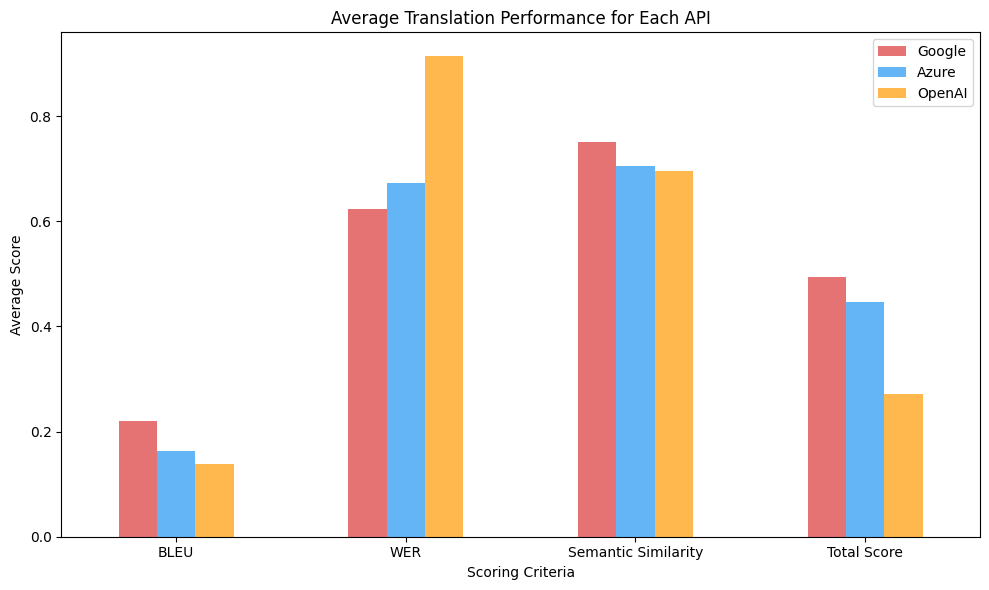

In [105]:
import os
import matplotlib.pyplot as plt
import pandas as pd

api_files = {
    'Google': 'google_translate_results.csv',
    'Azure': 'azure_translate_results.csv',
    'OpenAI': 'openai_translate_results.csv'
}

def load_and_average(api_files):
    averages = {}
    wer_values = []
    for api, file in api_files.items():
        if os.path.exists(file):
            df = pd.read_csv(file)
            avg_bleu = df['Bleu Score'].mean()
            avg_wer = df['Word Error Rate'].mean()
            avg_semantic_similarity = df['Semantic Similarity'].mean()
            avg_total_score = df['Total Score'].mean()
            averages[api] = {
                'BLEU': avg_bleu,
                'WER': avg_wer,
                'Semantic Similarity': avg_semantic_similarity,
                'Total Score': avg_total_score
            }
            wer_values.append(avg_wer)

    for api in averages:
        averages[api]['WER'] = (averages[api]['WER'] / 100)
        if averages[api]['WER'] > 1:
            averages[api]['WER'] = 1 - (averages[api]['WER'] - 1)

    return averages

averages = load_and_average(api_files)

averages_df = pd.DataFrame(averages)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#E57373', '#64B5F6', '#FFB84D']
averages_df.plot(kind='bar', ax=ax, color=colors)

ax.set_ylabel('Average Score')
ax.set_xlabel('Scoring Criteria')
ax.set_title('Average Translation Performance for Each API')

ax.set_xticklabels(averages_df.index, rotation=0)

plt.tight_layout()

plt.show()


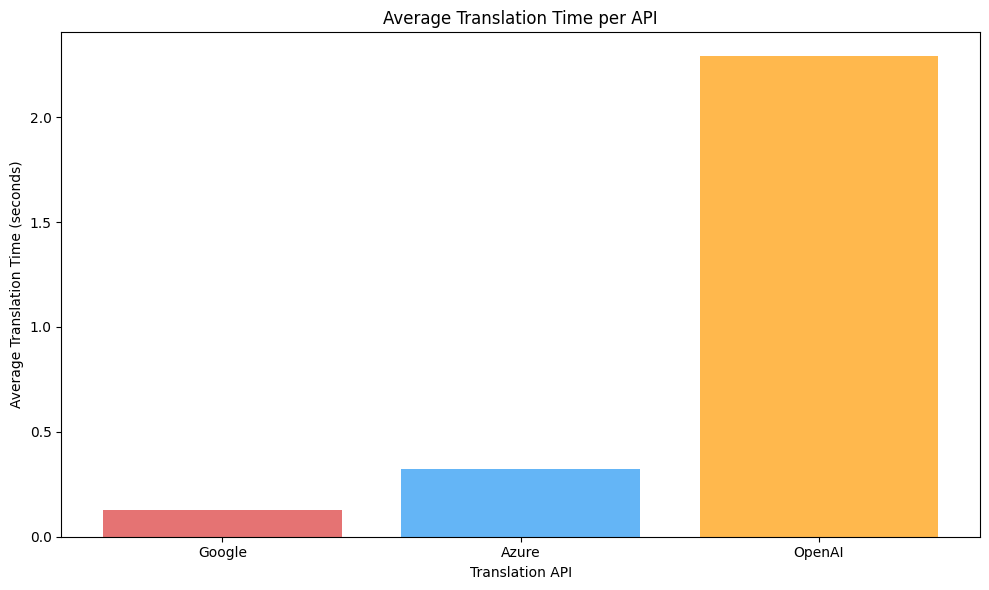

In [106]:
api_files = {
    'Google': 'google_translate_results.csv',
    'Azure': 'azure_translate_results.csv',
    'OpenAI': 'openai_translate_results.csv'
}

def load_and_average_time(api_files):
    time_averages = {}
    for api, file in api_files.items():
        if os.path.exists(file):
            df = pd.read_csv(file)
            avg_time = df['Translation Time (s)'].mean()
            time_averages[api] = avg_time
    return time_averages

time_averages = load_and_average_time(api_files)
time_averages_df = pd.DataFrame(list(time_averages.items()), columns=['API', 'Average Translation Time'])

colors = ['#E57373', '#64B5F6', '#FFB84D']

plt.figure(figsize=(10, 6))
plt.bar(time_averages_df['API'], time_averages_df['Average Translation Time'], color=colors)

plt.ylabel('Average Translation Time (seconds)')
plt.xlabel('Translation API')
plt.title('Average Translation Time per API')

# Show the plot
plt.tight_layout()
plt.show()


In [107]:
# Add cost per character for each API
cost_per_character = {
    'Google': 0.00002,
    'Azure': 0.00001,
    'OpenAI': 0.000013
}

# Merging the averages and time_averages data into one dictionary
merged_data = []
for api in api_files.keys():
    if api in averages and api in time_averages:
        merged_data.append({
            'API': api,
            'Translation Time (s)': time_averages[api],
            'BLEU': averages[api]['BLEU'],
            'WER': averages[api]['WER'],
            'Semantic Similarity': averages[api]['Semantic Similarity'],
            'Estimated Accuracy': averages[api]['Total Score'],
            'Cost per Character': cost_per_character.get(api, None)  # Add the cost per character
        })

# Convert merged data to DataFrame
merged_df = pd.DataFrame(merged_data)

# Save to CSV
merged_df.to_csv('averages.csv', index=False)

# Verify the data
merged_df.head()


,API,Translation Time (s),BLEU,WER,Semantic Similarity,Estimated Accuracy,Cost per Character
0,Google,0.128323,0.219567,0.623426,0.750549,0.494762,0.000020
1,Azure,0.322719,0.162280,0.672020,0.705881,0.446000,0.000010
2,OpenAI,2.290373,0.139021,0.913615,0.695697,0.271529,0.000013


In [108]:
import ipywidgets as widgets
from IPython.display import display, HTML

cost_per_character = {
    'Google': 0.00002,
    'Azure': 0.00001,
    'OpenAI': 0.000013
}

def calculate_cost(char_count):
    costs = {api: char_count * cost for api, cost in cost_per_character.items()}
    cost_display.value = '\n'.join([f"{api}: ${cost:.4f}" for api, cost in costs.items()])

title_label = HTML("<h2 style='text-align: center;'>API Cost Calculator</h2>")

char_slider = widgets.IntSlider(value=1000, min=0, max=1000000, step=100, description='Characters:')

cost_display = widgets.Textarea(
    value="",
    description="Costs:",
    disabled=True,
    layout=widgets.Layout(width='50%', height='100px')
)

widgets.interactive(calculate_cost, char_count=char_slider)

text_input = widgets.Textarea(
    placeholder="Enter text here...",
    description="Text Input:",
    layout=widgets.Layout(width='100%', height='150px')
)

def update_cost_from_text(change):
    char_count = len(text_input.value)
    char_slider.value = char_count
    calculate_cost(char_count)

text_input.observe(update_cost_from_text, names='value')

display(title_label, char_slider, text_input, cost_display)

calculate_cost(char_slider.value)


IntSlider(value=1000, description='Characters:', max=1000000, step=100)

Textarea(value='', description='Text Input:', layout=Layout(height='150px', width='100%'), placeholder='Enter …

Textarea(value='', description='Costs:', disabled=True, layout=Layout(height='100px', width='50%'))